In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter

#### Load a subset of the total data for initial testing:



Text(0, 0.5, 'Northing [m]')

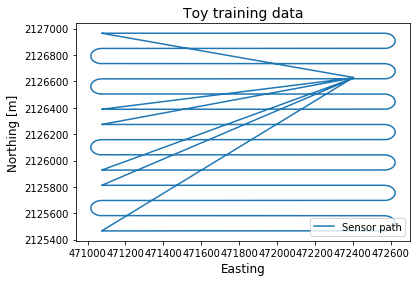

In [2]:
# The data contains 2D path information in a numeric format.
# For toy example: load a single simplistic survey for each for the training, validation, and testing datasets.
# The toy example surveys are cherry-picked to be somewhat similar, to enable testing on the subset.

# Seed randomizer so results can be reproduced if needed:
np.random.seed(100)
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(100)
    
datapath = 'project/' # Insert the path to the data here
survey = np.load(datapath + 'p2.npy') # Load the survey data
meta = np.load(datapath + 'p2_meta.npy') # This meta-survey information is known a priori
survey2 = np.load(datapath + 'p1.npy') # Load the survey data
meta2 = np.load(datapath + 'p1_meta.npy') # This meta-survey information is known a priori
survey3 = np.load(datapath + 'p3.npy') # Load the survey data
meta3 = np.load(datapath + 'p3_meta.npy') # This meta-survey information is known a priori

# Plot the training data
plt.figure()
plt.title('Toy training data',fontsize = 14)
plt.plot(survey[:,2], survey[:,3])
l0 = plt.legend(['Sensor path'], loc = 'lower right')
l0.legendHandles[0]._legmarker.set_markersize(10)
plt.xlabel('Easting',fontsize = 12)
plt.ylabel('Northing [m]',fontsize = 12)

In [3]:

seclen = 10 # Envelope size
dx = 10 # Samples per meter (only constant in the toy example)

# Load the three datasets

data = []
targ = []
survey = survey[::dx,:]
survey[:,2] = np.gradient(survey[:,2] + np.random.normal(len(survey)))
survey[:,3] = np.gradient(survey[:,3] + np.random.normal(len(survey)))
for i in range(len(survey)-seclen):
    data.append(survey[i:i+seclen,2:].flatten())
    targ.append(np.min([1,int(survey[i+int(seclen/2),0])]))

x_train = torch.FloatTensor(data)
targets_train = torch.LongTensor(targ)

data = []
targ = []
survey2 = survey2[::dx,:]
survey2[:,2] = np.gradient(survey2[:,2] + np.random.normal(len(survey2)))
survey2[:,3] = np.gradient(survey2[:,3] + np.random.normal(len(survey2)))
for i in range(len(survey2)-seclen):
    data.append(survey2[i:i+seclen,2:].flatten())
    targ.append(np.min([1,int(survey2[i+int(seclen/2),0])]))
    #targ.append(int(np.max(survey2[i:i+seclen,0])))

x_valid = torch.FloatTensor(data)
targets_valid = torch.LongTensor(targ)

data = []
targ = []
survey3 = survey3[::dx,:]
survey3[:,2] = np.gradient(survey3[:,2] + np.random.normal(len(survey3)))
survey3[:,3] = np.gradient(survey3[:,3] + np.random.normal(len(survey3)))
for i in range(len(survey3)-seclen):
    data.append(survey3[i:i+seclen,2:].flatten())
    targ.append(np.min([1,int(survey3[i+int(seclen/2),0])]))


x_test = torch.FloatTensor(data)
targets_test = torch.LongTensor(targ)

# Initial testing - A relatively simple FFNN

In [4]:
#Hyperparameters
N_classes = 2
N_l1 = 4
N_l2 = 5
N_l3 = 4
N_features = x_train.shape[1]
learning_rate = 1e-2
regularization = 1e-4

# define network
class Net(nn.Module):

    def __init__(self, N_features, N_hidden_1, N_hidden_2, N_hidden_3, N_output):
        super(Net, self).__init__()  

        # Layer 1
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(N_hidden_1, N_features))) # <- Kaiming He initialization
        self.b_1 = Parameter(init.constant_(torch.Tensor(N_hidden_1), 0))
        self.batch_norm_1 = nn.BatchNorm1d(N_hidden_1)
        self.dropout_1 = nn.Dropout(0.1, inplace = False)
        # Layer 2
        #self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden_1)))
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(N_hidden_2, N_hidden_1))) # <- Kaiming He initialization
        self.b_2 = Parameter(init.constant_(torch.Tensor(N_hidden_2), 0))
        self.batch_norm_2 = nn.BatchNorm1d(N_hidden_2)
        self.dropout_2 = nn.Dropout(0.1, inplace = True)

 #       # Hidden layer 2
 #       self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(N_hidden_3, N_hidden_2))) # <- Kaiming He initialization
 #       self.b_3 = Parameter(init.constant_(torch.Tensor(N_hidden_3), 0))
 #       self.batch_norm_3 = nn.BatchNorm1d(N_hidden_3)
#        self.dropout_3 = nn.Dropout(0.1, inplace = False)
                                    
        # Hidden layer 3
        self.W_4 = Parameter(init.kaiming_uniform_(torch.Tensor(N_output, N_hidden_2))) # <- Kaiming He initialization
        self.b_4 = Parameter(init.constant_(torch.Tensor(N_output), 0))


        # Rectified Linear Unit (ReLU) Activation function 
        self.activation = torch.nn.ReLU()
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.batch_norm_1(x)
#        x = self.dropout_1(x)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.batch_norm_2(x)
#        x = self.dropout_2(x)
        x = self.activation(x)
#        x = F.linear(x, self.W_3, self.b_3)
#        x = self.batch_norm_3(x)
#        x = self.activation(x)
#        x = self.dropout_3(x)
        x = F.linear(x, self.W_4, self.b_4)
       # x = self.sig(x)
        return F.softmax(x,dim=1)


# Build the neural network
network = Net(N_features, N_l1, N_l2, N_l3, N_classes)

# Set optimization strategy and criteria
#optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=0.9, weight_decay = regularization)
optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay = regularization)
criterion = nn.CrossEntropyLoss()

#### Training loop:

Epoch    0 | Train Loss: 0.00095799 | Validation Loss: 0.00191349 | Train acc: 0.65705714 | Validation acc: 0.50847143
Epoch   10 | Train Loss: 0.00059030 | Validation Loss: 0.00140233 | Train acc: 0.91102857 | Validation acc: 0.78494286
Epoch   20 | Train Loss: 0.00052546 | Validation Loss: 0.00111657 | Train acc: 0.91397143 | Validation acc: 0.88025714
Epoch   30 | Train Loss: 0.00051391 | Validation Loss: 0.00100250 | Train acc: 0.91468571 | Validation acc: 0.95700000
Epoch   40 | Train Loss: 0.00050894 | Validation Loss: 0.00096804 | Train acc: 0.91522857 | Validation acc: 0.95657143
Epoch   50 | Train Loss: 0.00050650 | Validation Loss: 0.00096266 | Train acc: 0.91582857 | Validation acc: 0.95644286
Epoch   60 | Train Loss: 0.00051838 | Validation Loss: 0.00116681 | Train acc: 0.91451429 | Validation acc: 0.87957143
Epoch   70 | Train Loss: 0.00051050 | Validation Loss: 0.00120986 | Train acc: 0.91337143 | Validation acc: 0.86247143
Epoch   80 | Train Loss: 0.00050784 | Validation

Text(0, 0.5, 'Accuracy')

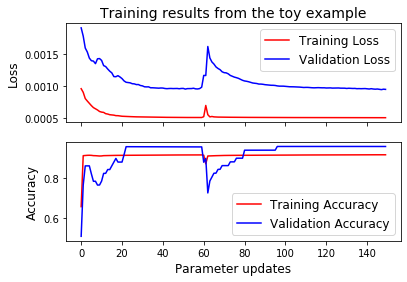

In [5]:
# Please note that the training loop code stems majorly from prior exercises

from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 5000
num_epochs = 150
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):

    ## Train
    cur_loss = 0
    network.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = network(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss
        
    train_loss.append(cur_loss / batch_size)

    network.eval()

    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = network(x_train[slce])

        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = network(x_valid[slce])
        target_batch = targets_valid[slce]
        batch_loss = criterion(output, target_batch)
        cur_loss += batch_loss

        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        
    valid_loss.append(cur_loss / batch_size)

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %4i | Train Loss: %.8f | Validation Loss: %.8f | Train acc: %.8f | Validation acc: %.8f" % (
                epoch, train_loss[-1], valid_loss[-1], train_acc[-1], valid_acc[-1]))
        
epoch = np.arange(len(train_acc))

fig, (ax0,ax1) = plt.subplots(2,1,sharex = True, sharey = False)
ax0.set_title('Training results from the toy example',fontsize = 14)
ax0.plot(epoch, train_loss, 'r')
ax0.plot(epoch, valid_loss, 'b')
ax0.legend(['Training Loss','Validation Loss'],fontsize = 12)
ax0.set_ylabel('Loss',fontsize=12)

ax1.plot(epoch, train_acc, 'r')
ax1.plot( epoch, valid_acc, 'b')
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize = 12)
ax1.set_xlabel('Parameter updates',fontsize=12)
ax1.set_ylabel('Accuracy',fontsize=12)


#### Lets see how well it performs the prediction:

In [6]:
test_result = torch.argmax(network(x_test),dim=1) # Get the class numbers
N_correct = torch.sum(targets_test == test_result)
N_total = len(test_result)

print('Accuracy of the network on the test dataset: {:4.2f} %'.format(100 * N_correct/N_total))


Accuracy of the network on the test dataset: 99.00 %


#### Plot the toy results

Text(0.5, 1.0, 'Toy example test: predicted non-lines')

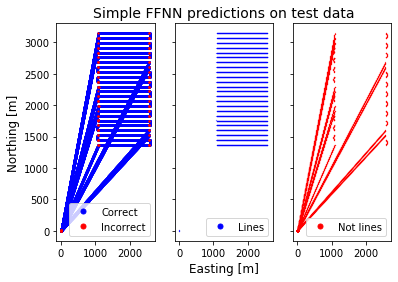

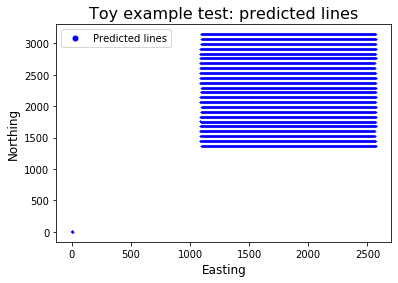

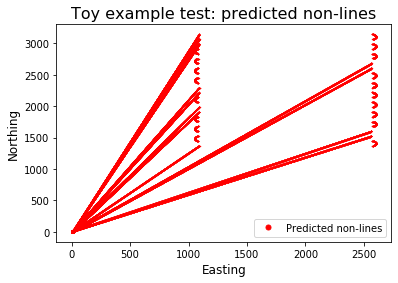

In [7]:
survey = np.load(datapath + 'p2.npy') # Re-Load the test survey data
survey2 = np.load(datapath + 'p1.npy') # Re-Load the test survey data
survey3 = np.load(datapath + 'p3.npy') # Re-Load the test survey data
survey3 = survey3[int(seclen*dx/2):-int(seclen*dx/2):dx,:]

survey3[:,2] -= np.min(survey3[:,2])
survey3[:,3] -= np.min(survey3[:,3])

fig, (ax0,ax1,ax2) = plt.subplots(1,3,sharex = True, sharey = True)
ax1.set_title('Simple FFNN predictions on test data',fontsize = 14)
ax0.plot(survey3[(targets_test == test_result),2], survey3[(targets_test == test_result),3], 'b.',markersize=2)
ax0.plot(survey3[(targets_test != test_result),2], survey3[(targets_test != test_result),3], 'r.',markersize=2)
l0 = ax0.legend(['Correct','Incorrect'], loc = 'lower right')
l0.legendHandles[0]._legmarker.set_markersize(10)
l0.legendHandles[1]._legmarker.set_markersize(10)
#ax0.set_xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
ax0.set_ylabel('Northing [m]',fontsize = 12)

ax1.plot(survey3[(test_result == 0),2], survey3[(test_result == 0),3], 'b.',markersize=0.1)
l1 = ax1.legend(['Lines'], loc = 'lower right')
l1.legendHandles[0]._legmarker.set_markersize(10)
ax1.set_xlabel('Easting [m]',fontsize = 12)#, plt.ylabel('Northing',fontsize = 12)

ax2.plot(survey3[(test_result == 1),2], survey3[(test_result == 1),3], 'r.',markersize=0.1)
l2 = ax2.legend(['Not lines'], loc = 'lower right')
l2.legendHandles[0]._legmarker.set_markersize(10)

plt.figure()
plt.plot(survey3[(test_result == 0),2], survey3[(test_result == 0),3], 'b.',markersize=1)
l1 = plt.legend(['Predicted lines'])
l1.legendHandles[0]._legmarker.set_markersize(10)
plt.xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
plt.title('Toy example test: predicted lines',fontsize = 16)

plt.figure()
plt.plot(survey3[(test_result == 1),2], survey3[(test_result == 1),3], 'r.',markersize=1)
l1 = plt.legend(['Predicted non-lines'])
l1.legendHandles[0]._legmarker.set_markersize(10)
plt.xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
plt.title('Toy example test: predicted non-lines',fontsize = 16)


#### Notes (when using only ONE synthetic training survey):
Obviusly very prone to overfitting.
Too many nodes and too many layers have a strong tendency to overfit.
Regularization and in particular batchnorm reduce the amount of overfitting.

#### Some particularly interesting results with only one synth. training survey, with added white noise:

80% Validation acc obtained with Adam with 1e-3 LR, 1e-2 Reg; 2 Sigmoid HL's with 24 and 8 nodes (both layers w. Kaiming He, batchnorm, and ReLU)
80% Validation acc also obtained when using the above with less nodes (as few as 8 and 4, for the two respective hidden layers, or alternatively 5 and 5), suggesting that the synthesized features are relatively simple (which is indeed correct at this stage). Interestingly, if the main source of mis-classification in the test data occurred between the turn and landing classes, i.e., the line class, which is the main class of interest, was well predicted using the network. This is most likely due to similarities between true turns and turning into lines, and suggests that reducing the number of classes to two may produce good results. This was revealed to be true following further tests with only two classes (interesting data and uninteresting data), where a validation accuraccy of more than 98.1% was obtained (with a training accurracy of 99.9%).

#### Take-aways from the initial tests
The initial tests confirm what was expected: It is indeed possible to extract information on the different classes using machine learning, suggesting that this should be pursued further. I therefore construct a number of objectives in the form of statements/hypothesis, based on the findings here and other a priori information.

##### 1. The main body of the data consists of relatively simple features.
This is backed somewhat by the simplicity and shallowness of the NNs required to obtain an 80% validation acc. As such, I initially expect that at least some part of the ideal network should be shallow or only of limited depth (1-2 layers).

##### 2. Deeper layers are probably needed to correctly resolve the true data.
This is based on a priori information: Some dynamics of the data collection system can cause different classes to appear alike. The devil is in the higher-order details in this case - and the question is therefore whether we may learn these deep features without overfitting. Considering this in addition to point 1, it may be prudent to partition the final NN, and to do so in a way that allows direct infleunce on the final classification from a combination of shallow and deep nodes.

##### 3. Information on the movement must be encoded somehow, either through data transform/pre-processing, or through network architecture considerations.
Since the movement is the primary piece of information, and since it can only be measured across multiple data points, there is a  choice to be made: Either the movement information is encoded in the data, by performing an initial transform into sections (as has been done in the initial tests), or the sequential nature of the data must be handled in the network achitechture (e.g., through Recurrent NN, which is well suited for sequential data).

##### 4. There is more potential in training the NN on real data, than when training it on synthetic data.
Due to the complexity of the real survey data, it cannot be expected that synthetic data can be constructed in such a way that all details in the real data may be captured. However, accuss to those details carry a risk of overfitting, so I may not be able to realize their potential regardless. Certain, however, is the disparity between the synthetic and real data, which suggests that tests on real data are required, before any conclusions on the validity (and usefulness) of the approach can be made.

#### Import, normalize, and show real dataset

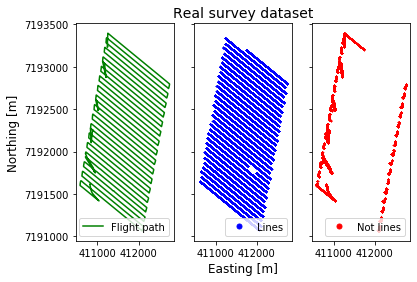

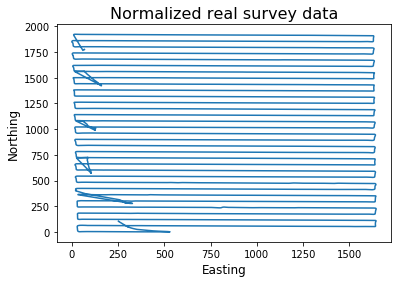

In [8]:
datapath = 'project/'
realdata = np.load(datapath+'real_with_targets.npy')

fig, (ax0,ax1,ax2) = plt.subplots(1,3,sharex = True, sharey = True)
ax1.set_title('Real survey dataset',fontsize = 14)
ax0.plot(realdata[:,1], realdata[:,2], 'g')
l0 = ax0.legend(['Flight path'], loc = 'lower right')
l0.legendHandles[0]._legmarker.set_markersize(10)
#ax0.set_xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
ax0.set_ylabel('Northing [m]',fontsize = 12)

ax1.plot(realdata[(realdata[:,-1]==0),1], realdata[(realdata[:,-1]==0),2], 'b.',markersize=0.25)
l1 = ax1.legend(['Lines'], loc = 'lower right')
l1.legendHandles[0]._legmarker.set_markersize(10)
ax1.set_xlabel('Easting [m]',fontsize = 12)#, plt.ylabel('Northing',fontsize = 12)

ax2.plot(realdata[(realdata[:,-1]==1),1], realdata[(realdata[:,-1]==1),2], 'r.',markersize=0.25)
l2 = ax2.legend(['Not lines'], loc = 'lower right')
l2.legendHandles[0]._legmarker.set_markersize(10)

# Normalize by rotating the survey (to match the synthetic data normalization)
t =-21.3*np.pi/180
rotmat = np.array([[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]])
realdata[:,1:3] = realdata[:,1:3].dot(rotmat)
realdata[:,1] -= np.min(realdata[:,1])
realdata[:,2] -= np.min(realdata[:,2])
plt.figure()
plt.plot(realdata[:,1],realdata[:,2])
plt.xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
plt.title('Normalized real survey data',fontsize = 16)


# Prepare the data so it can be fed to the neural networks
realdata10, realtarg10 = [], []
#realdata = realdata[::10,:]
realpos10 = np.copy(realdata[:,1:3])
realdata[:,1] = np.gradient(realdata[:,1])
realdata[:,2] = np.gradient(realdata[:,2])
for i in range(0,len(realdata)-12,10): # For the toy NN
    realdata10.append(realdata[i:i+seclen,1:3].flatten())
    realtarg10.append(np.min([1,int(realdata[i+int(10/2),-1])]))

realdata10 = np.array(realdata10)
realtarg10 = np.array(realtarg10)

#### Evaluate the classification of real data using toy network

Accuracy of the toy network on the real dataset: 46.00 %


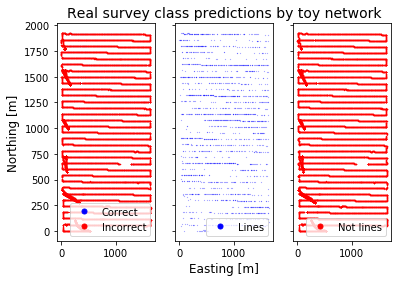

In [9]:
test_result = torch.argmax(network(torch.FloatTensor(realdata10)),dim=1) # Get the class numbers
N_correct = torch.sum(torch.LongTensor(realtarg10) == test_result)
N_total = len(test_result)

realpos10 = realpos10[:-10:10,:]

print('Accuracy of the toy network on the real dataset: {:4.2f} %'.format(100 * N_correct/N_total))

fig, (ax0,ax1,ax2) = plt.subplots(1,3,sharex = True, sharey = True)
ax1.set_title('Real survey class predictions by toy network',fontsize = 14)
ax0.plot(realpos10[(test_result==0),0], realpos10[(test_result==0),1], 'b.',markersize=0.25)
ax0.plot(realpos10[(test_result==1),0], realpos10[(test_result==1),1], 'r.',markersize=0.25)
l0 = ax0.legend(['Correct','Incorrect'], loc = 'lower right')
l0.legendHandles[0]._legmarker.set_markersize(10)
l0.legendHandles[1]._legmarker.set_markersize(10)
#ax0.set_xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
ax0.set_ylabel('Northing [m]',fontsize = 12)

ax1.plot(realpos10[(test_result==0),0], realpos10[(test_result==0),1], 'b.',markersize=0.25)
l1 = ax1.legend(['Lines'], loc = 'lower right')
l1.legendHandles[0]._legmarker.set_markersize(10)
ax1.set_xlabel('Easting [m]',fontsize = 12)#, plt.ylabel('Northing',fontsize = 12)

ax2.plot(realpos10[(test_result==1),0], realpos10[(test_result==1),1], 'r.',markersize=0.25)
l2 = ax2.legend(['Not lines'], loc = 'lower right')
l2.legendHandles[0]._legmarker.set_markersize(10)

# The toy network is useless for real data!

# ---------- Toy example finished! ----------

# Start the main classification effort: Import all realistic synthetic data
#### If using a machine with limited RAM (<16Gb), you may need to reduce the amount of input surveys.

Files checked and ready. Data import commencing ...
... Data import concluded!


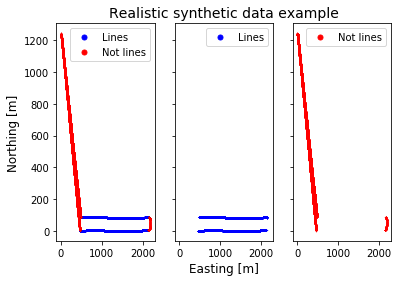

In [10]:
# Now load all the realistic data
import glob, os
import scipy.interpolate

datapath = 'project/maindata' # Insert the path to the project folder here

#Get counts on the files available
Nfiles = len(glob.glob(datapath+"/*.npy"))
Nmetafiles = len(glob.glob(datapath+"/*meta.npy"))

if ((np.round(Nfiles/2) == Nfiles/2) and (2*Nmetafiles == Nfiles)):
    print('Files checked and ready. Data import commencing ...')

# Extract all data and targets into single containers, normalizing each survey using its metaparameters

seclen = 100 # each normalized section will be resampled to this amount of data points
data = []
targ = []
meta = []

for j in range(10):
    survey = np.load(datapath+'/surv_'+str(j)+'.npy')
    metainfo = np.load(datapath+'/surv_'+str(j)+'_meta.npy')
    normfactor = metainfo[0]*metainfo[1] # Normalization factor (data requried to span two line spacings)
    #print(normfactor)
    #Interpolate gradient and targets
#    S_interp = scipy.interpolate.interp1d(range(len(survey)),np.c_[np.gradient(survey[:,2:4],axis=0),survey[:,0]],axis=0)
    survey[:,2] = np.gradient(survey[:,2])
    survey[:,3] = np.gradient(survey[:,3])
    for i in range(0,len(survey)-int(seclen)-1,10):
        data.append(survey[i:i+seclen,2:])
        targ.append(np.min([1,int(survey[i+int(seclen/2),0])]))
#        data.append(S_interp(np.linspace(i,i+normfactor,seclen))[:,:2])
#        targ.append(survey[i+int(normfactor/2),0])#int(S_interp(np.linspace(i,i+normfactor,seclen))[i+int(seclen/2),2]))
        meta.append(metainfo)
        
    print('File '+str(j+1)+' of '+str(Nmetafiles)+' imported.', end="\r", flush=True)
    
data = np.array(data)
targ = np.array(targ)
meta = np.array(meta)
print('... Data import concluded!')

# Plot a synthetic survey
j = 5
survey = np.load(datapath+'/surv_'+str(j)+'.npy')

survey[:,2] -= np.min(survey[:,2])
survey[:,3] -= np.min(survey[:,3])

fig, (ax0,ax1,ax2) = plt.subplots(1,3,sharex = True, sharey = True)
ax1.set_title('Realistic synthetic data example',fontsize = 14)
ax0.plot(survey[(survey[:,0] == 0),2], survey[(survey[:,0] == 0),3], 'b.',markersize=0.2)
ax0.plot(survey[(survey[:,0] >= 1),2], survey[(survey[:,0] >= 1),3], 'r.',markersize=0.2)
l0 = ax0.legend(['Lines','Not lines'], loc = 'upper right')
l0.legendHandles[0]._legmarker.set_markersize(10)
l0.legendHandles[1]._legmarker.set_markersize(10)
#ax0.set_xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
ax0.set_ylabel('Northing [m]',fontsize = 12)

ax1.plot(survey[(survey[:,0] == 0),2], survey[(survey[:,0] == 0),3], 'b.',markersize=0.2)
l1 = ax1.legend(['Lines'], loc = 'upper right')
l1.legendHandles[0]._legmarker.set_markersize(10)
ax1.set_xlabel('Easting [m]',fontsize = 12)#, plt.ylabel('Northing',fontsize = 12)

ax2.plot(survey[(survey[:,0] >= 1),2], survey[(survey[:,0] >= 1),3], 'r.',markersize=0.2)
l2 = ax2.legend(['Not lines'], loc = 'upper right')
l2.legendHandles[0]._legmarker.set_markersize(10)


### Partition data into training and test data:

In [11]:

data = np.swapaxes(data, 1, 2)

print("%d Megabytes of memory consumed by data" % (data.size * data.itemsize / 1e6))

print(targ.shape)

614 Megabytes of memory consumed by data
(383809,)


In [12]:
x_train = torch.FloatTensor(data[:int(len(targ)*0.7),:])
targets_train = torch.LongTensor(targ[:int(len(targ)*0.7)])

x_test = torch.FloatTensor(data[int(len(targ)*0.7):,:])
targets_test = torch.LongTensor(targ[int(len(targ)*0.7):])


#### Design the network

In [13]:
#Hyperparameters
N_classes = 2
N_datachannels = 2 # This is the original amount of channels

# Channels for 1D convolutional layers
N_c1 = 4
N_c2 = 2
N_c3 = 2

# Time series length after convolutions in convolution branch
L_out = 25

# Fully connected layers (amount of nodes)
N_l1 = 4
N_l2 = 4
N_l3 = 4

# Length of dataseries input to fully connected branch
N_data = 81*2

# Fully connected layers inside fully connected branch (amount of nodes)
N_B1 = 4
N_B2 = 4

learning_rate = 1e-2 # tried increments of 1e-1 from 1 to 1e-14
regularization = 1e-5# tried increments of 1e-1 from 1e-1 to 1e-9

def compute_conv_dim(indim,kernel,padding,stride):
    return int((indim - kernel + 2 * padding) / stride + 1)

# define network
class Net(nn.Module):

    def __init__(self, Nc_in, Nc_1, Nc_2, L_out, Nf_2, Nf_3, Nf_4, Nf_out, Nf_1B, Nf_2B, N_in):
        super(Net, self).__init__()  
        
        # Branch One (Convolutional)
        self.conv_1A = nn.Conv1d(Nc_in, Nc_1,kernel_size = 20,stride = 1,padding = 0) # L_out is now 81
        
        self.pool_1A = nn.MaxPool1d(3) # L_out is now 27
        self.conv_2A = nn.Conv1d(Nc_1-2, Nc_2,kernel_size = 3,stride = 1) # L_out is now  25
        #self.pool_2A = nn.MaxPool1d(5) # L_out is now 5
        
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(Nf_2, L_out * Nc_2)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(Nf_2), 0))
        self.batch_norm_1 = nn.BatchNorm1d(Nf_2)

        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(Nf_3, Nf_2)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(Nf_3), 0))
        self.batch_norm_2 = nn.BatchNorm1d(Nf_3)
        
        # Branch Two (fully connected, like in the toy example)
        self.W_1B = Parameter(init.kaiming_uniform_(torch.Tensor(Nf_1B, N_in)))
        self.b_1B = Parameter(init.constant_(torch.Tensor(Nf_1B),0))
        self.batch_norm_1B = nn.BatchNorm1d(Nf_1B)

        self.W_2B = Parameter(init.kaiming_uniform_(torch.Tensor(Nf_2B, Nf_1B)))
        self.b_2B = Parameter(init.constant_(torch.Tensor(Nf_2B), 0))
        self.batch_norm_2B = nn.BatchNorm1d(Nf_2B)
        
        
        # Output
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(Nf_4, Nf_2B+Nf_3)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(Nf_4), 0))
        self.batch_norm_3 = nn.BatchNorm1d(Nf_4)
        
        self.W_4 = Parameter(init.kaiming_uniform_(torch.Tensor(Nf_out, Nf_4)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(Nf_out), 0))
        
        
        
        self.activation = torch.nn.ReLU()
        self.dropout = nn.Dropout(0.1, inplace = True)
        self.pool = nn.MaxPool1d(2)
        
    def forward(self, x):
        x = F.relu(self.conv_1A(x))
        xA, xB = torch.split(x,N_c1-2,dim=1)
        xA = self.pool_1A(xA)
        xA = F.relu(self.conv_2A(xA))
        #xA = self.pool_2A(xA)
        xA = xA.view(-1, 25 * 2)
        
        xB = F.linear(xB.flatten(start_dim = 1,end_dim = 2), self.W_1B, self.b_1B)
        xB = self.batch_norm_1B(xB)
        xB = self.dropout(xB)
        xB = self.activation(xB)
        
        xB = F.linear(xB, self.W_2B, self.b_2B)
        xB = self.batch_norm_2B(xB)
        xB = self.dropout(xB)
        xB = self.activation(xB)   
        
        xA = F.linear(xA, self.W_1, self.b_1)
        xA = self.batch_norm_1(xA)
        xA = self.dropout(xA)
        xA = self.activation(xA)
        
        xA = F.linear(xA, self.W_2, self.b_2)
        xA = self.batch_norm_2(xA)
        xA = self.activation(xA)
        
        x = torch.cat((xA,xB),1)
        x = F.linear(x, self.W_3, self.b_3)
        x = self.batch_norm_3(x)
        x = self.activation(x)
        
        x = F.linear(x, self.W_4, self.b_4)
        
        return F.softmax(x,dim=1)


# Build the neural network
cnet = Net(N_datachannels, N_c1, N_c2, L_out, N_l1, N_l2, N_l3, N_classes, N_B1, N_B2, N_data)

criterion = nn.CrossEntropyLoss() #BCELoss()
#optimizer = optim.SGD(cnet.parameters(), lr=learning_rate, weight_decay = regularization, momentum = 0.999)
optimizer = optim.Adam(cnet.parameters(), lr=learning_rate, weight_decay = regularization)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnet.to(device)

Net(
  (conv_1A): Conv1d(2, 4, kernel_size=(20,), stride=(1,))
  (pool_1A): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_2A): Conv1d(2, 2, kernel_size=(3,), stride=(1,))
  (batch_norm_1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_1B): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2B): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.1, inplace=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [14]:
# Check a forward pass on a batch of 10 
cnet(x_train[125:135,:,:].view(10,2,100))


tensor([[0.6916, 0.3084],
        [0.5590, 0.4410],
        [0.5324, 0.4676],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5219, 0.4781],
        [0.5000, 0.5000],
        [0.3211, 0.6789],
        [0.3025, 0.6975],
        [0.0123, 0.9877]], grad_fn=<SoftmaxBackward>)

In [15]:
# Training loop code stems majorly from prior exercises

from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 5000
num_epochs = 9
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_test.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):

    ## Train
    cur_loss = 0
    cnet.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = cnet(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss
    train_loss.append(cur_loss / batch_size)

    cnet.eval()

    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = cnet(x_train[slce])

        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        output = cnet(x_test[slce])
        target_batch = targets_test[slce]
        batch_loss = criterion(output, target_batch)
        cur_loss += batch_loss

        preds = torch.max(output, 1)[1]
        val_targs += list(targets_test[slce].numpy())
        val_preds += list(preds.data.numpy())
        
    valid_loss.append(cur_loss / batch_size)

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 1 == 0:
        print("Epoch %4i | Train Loss: %.8f | Validation Loss: %.8f" % (
                epoch, train_loss[-1], valid_loss[-1]))
        
    nonlinecorrect = 0
    nonlinetotal = 0
    linecorrect = 0
    linetotal = 0
    correct = 0
    total = 0


    inputs = x_test#[:,:,:]#.view(1,2,100) # need to add view when operating single sections (to keep correct dimensions)
    labels = targets_test#[i]#.view(-1)

    outputs = cnet(inputs)
    _, predicted = torch.max(outputs,1)
    total += len(labels)
    correct += (predicted == labels).sum().item()

    linecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==0]).sum().item()
    linetotal += (labels == 0).sum().item()
    nonlinecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==1]).sum().item()
    nonlinetotal += (labels == 1).sum().item()


    print('Total Accuracy: {:4.2f} ; Line points classified correct: {:4.2f} ; non-line points classified correct {:4.2f} %'.format(
    100 * correct/total, 100 * linecorrect/linetotal, 100 * nonlinecorrect/nonlinetotal))

epoch = np.arange(len(train_acc))

Epoch    0 | Train Loss: 0.00610340 | Validation Loss: 0.00257589
Total Accuracy: 77.97 ; Line points classified correct: 73.01 ; non-line point classified correct 92.92 %
Epoch    1 | Train Loss: 0.00513899 | Validation Loss: 0.00185014
Total Accuracy: 93.53 ; Line points classified correct: 99.89 ; non-line point classified correct 74.36 %
Epoch    2 | Train Loss: 0.00482473 | Validation Loss: 0.00191837
Total Accuracy: 89.08 ; Line points classified correct: 99.87 ; non-line point classified correct 56.55 %
Epoch    3 | Train Loss: 0.00466011 | Validation Loss: 0.00181303
Total Accuracy: 92.69 ; Line points classified correct: 99.92 ; non-line point classified correct 70.91 %
Epoch    4 | Train Loss: 0.00449978 | Validation Loss: 0.00155397
Total Accuracy: 97.39 ; Line points classified correct: 99.63 ; non-line point classified correct 90.64 %
Epoch    5 | Train Loss: 0.00447335 | Validation Loss: 0.00174029
Total Accuracy: 93.36 ; Line points classified correct: 99.95 ; non-line p

In [16]:
# Evaluate the capeabilities of the trained network

nonlinecorrect = 0
nonlinetotal = 0
linecorrect = 0
linetotal = 0
correct = 0
total = 0


inputs = x_test#[:,:,:]#.view(1,2,100) # need to add view when operating single sections (to keep correct dimensions)
labels = targets_test#[i]#.view(-1)

print(torch.max(labels))

outputs = cnet(inputs)
_, predicted = torch.max(outputs,1)
total += len(labels)
correct += (predicted == labels).sum().item()
#print(total)
#print(predicted)
#print(labels)

linecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==0]).sum().item()
linetotal += (labels == 0).sum().item()
nonlinecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==1]).sum().item()
nonlinetotal += (labels == 1).sum().item()


print('Accuracy of the network on the {} test data: {:4.2f} %'.format(
    len(x_test), 100 * correct/total))

print('Amount of the {} non-line points actually classified as non-line points: {:4.2f} %'.format(
    nonlinetotal, 100 * nonlinecorrect/nonlinetotal))

print('Amount of the {} line points actually classified as line points: {:4.2f} %'.format(
    linetotal, 100 * linecorrect/linetotal))

tensor(1)
Accuracy of the network on the 115143 test data: 98.56 %
Amount of the 28676 non-line points actually classified as non-line points: 96.14 %
Amount of the 86467 line points actually classified as line points: 99.36 %


tensor(1)
Accuracy of the network on the 115143 real data: 97.15 %
Amount of the 35791 real non-line points actually classified as non-line points: 96.03 %
Amount of the 95001 real line points actually classified as line points: 97.57 %


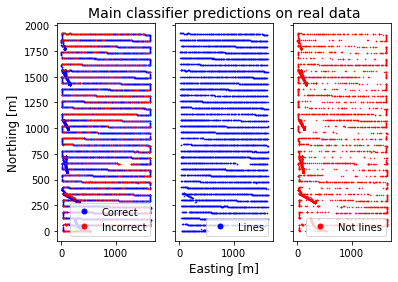

In [17]:
realdata = np.load('project/real_with_targets.npy')
t =-21.3*np.pi/180
rotmat = np.array([[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]])
realdata[:,1:3] = realdata[:,1:3].dot(rotmat)
real = np.copy(realdata)
realdata[:,1] = np.gradient(realdata[:,1])
realdata[:,2] = np.gradient(realdata[:,2])
realdata100, realtarg100 = [], []
for i in range(0,len(realdata)-102,100): # For the main NN
    realdata100.append(realdata[i:i+100,1:3])
    realtarg100.append(np.min([1,int(realdata[i+int(100/2),-1])]))

realdata100 = np.array(realdata100)
realtarg100 = np.array(realtarg100)
realdata100 = np.swapaxes(realdata100, 1, 2)

inputs = torch.FloatTensor(realdata100)
labels = torch.LongTensor(realtarg100)

print(torch.max(labels))

outputs = cnet(inputs)
_, predicted = torch.max(outputs,1)
total += len(labels)
correct += (predicted == labels).sum().item()

linecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==0]).sum().item()
linetotal += (labels == 0).sum().item()
nonlinecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==1]).sum().item()
nonlinetotal += (labels == 1).sum().item()


print('Accuracy of the network on the {} real data: {:4.2f} %'.format(
    len(x_test), 100 * correct/total))

print('Amount of the {} real non-line points actually classified as non-line points: {:4.2f} %'.format(
    nonlinetotal, 100 * nonlinecorrect/nonlinetotal))

print('Amount of the {} real line points actually classified as line points: {:4.2f} %'.format(
    linetotal, 100 * linecorrect/linetotal))

realdata = np.copy(real[:-102:100,:])
realdata[:,1] -= np.min(realdata[:,1])
realdata[:,2] -= np.min(realdata[:,2])



fig, (ax0,ax1,ax2) = plt.subplots(1,3,sharex = True, sharey = True)
ax1.set_title('Main classifier predictions on real data',fontsize = 14)
ax0.plot(realdata[(predicted == labels),1], realdata[(predicted == labels),2], 'b.',markersize=1)
ax0.plot(realdata[(predicted != labels),1], realdata[(predicted != labels),2], 'r.',markersize=1)
l0 = ax0.legend(['Correct','Incorrect'], loc = 'lower right')
l0.legendHandles[0]._legmarker.set_markersize(10)
l0.legendHandles[1]._legmarker.set_markersize(10)
#ax0.set_xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
ax0.set_ylabel('Northing [m]',fontsize = 12)

ax1.plot(realdata[(predicted==0),1], realdata[(predicted==0),2], 'b.',markersize=1)
l1 = ax1.legend(['Lines'], loc = 'lower right')
l1.legendHandles[0]._legmarker.set_markersize(10)
ax1.set_xlabel('Easting [m]',fontsize = 12)#, plt.ylabel('Northing',fontsize = 12)

ax2.plot(realdata[(predicted==1),1], realdata[(predicted==1),2], 'r.',markersize=1)
l2 = ax2.legend(['Not lines'], loc = 'lower right')
l2.legendHandles[0]._legmarker.set_markersize(10)


tensor(1)
Accuracy of the network on the 9691 test data: 99.03 %
Amount of the 5474 non-line points actually classified as non-line points: 98.41 %
Amount of the 4217 line points actually classified as line points: 99.83 %


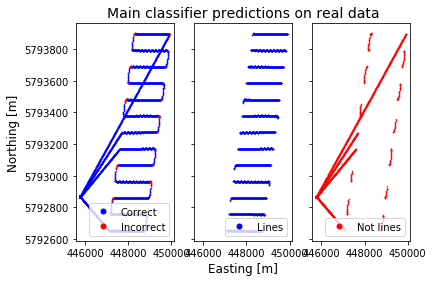

In [18]:
data = []
targ  =[]
meta = []
yc = []
xc = []
seclen = 100
survey = np.load(datapath+'/surv_'+str(8)+'.npy')
metainfo = np.load(datapath+'/surv_'+str(8)+'_meta.npy')
normfactor = metainfo[0]*metainfo[1] # Normalization factor (data requried to span two line spacings)
sX = np.copy(survey[:,2]) # For easy plotting later
sY = np.copy(survey[:,3])
survey[:,2] = np.gradient(survey[:,2])
survey[:,3] = np.gradient(survey[:,3])
for i in range(0,len(survey)-int(seclen)-1,10):
    data.append(survey[i:i+seclen,2:])
    targ.append(np.min([1,int(survey[i+int(seclen/2),0])])) # Binary classification makes more sense
    meta.append(metainfo)
    xc.append(sX[i+int(seclen/2)])
    yc.append(sY[i+int(seclen/2)])
    
data = np.array(data)
targ = np.array(targ)
meta = np.array(meta)
data = np.swapaxes(data, 1, 2)




nonlinecorrect = 0
nonlinetotal = 0
linecorrect = 0
linetotal = 0
correct = 0
total = 0

#for i in range(len(x_test)):
        
x_test = torch.FloatTensor(data)
targets_test = torch.LongTensor(targ)

inputs = x_test
labels = targets_test

print(torch.max(labels))

outputs = cnet(inputs)
_, predicted = torch.max(outputs,1)
total += len(labels)
correct += (predicted == labels).sum().item()
#print(total)
#print(predicted)
#print(labels)

linecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==0]).sum().item()
linetotal += (labels == 0).sum().item()
nonlinecorrect += np.array([l == p for l,p in zip(labels,predicted) if p==1]).sum().item()
nonlinetotal += (labels == 1).sum().item()


print('Accuracy of the network on the {} test data: {:4.2f} %'.format(
    len(x_test), 100 * correct/total))

print('Amount of the {} non-line points actually classified as non-line points: {:4.2f} %'.format(
    nonlinetotal, 100 * nonlinecorrect/nonlinetotal))

print('Amount of the {} line points actually classified as line points: {:4.2f} %'.format(
    linetotal, 100 * linecorrect/linetotal))



survey = np.load(datapath+'/surv_'+str(10)+'.npy')
metainfo = np.load(datapath+'/surv_'+str(10)+'_meta.npy')

survey[:,2] -= np.min(survey[:,2])
survey[:,3] -= np.min(survey[:,3])

realdata = np.copy(survey[:-102:,1:])

xc = np.array(xc)
yc = np.array(yc)

fig, (ax0,ax1,ax2) = plt.subplots(1,3,sharex = True, sharey = True)
ax1.set_title('Main classifier predictions on real data',fontsize = 14)
ax0.plot(xc[(predicted == labels)], yc[(predicted == labels)], 'b.',markersize=1)
ax0.plot(xc[(predicted != labels)], yc[(predicted != labels)], 'r.',markersize=1)
l0 = ax0.legend(['Correct','Incorrect'], loc = 'lower right')
l0.legendHandles[0]._legmarker.set_markersize(10)
l0.legendHandles[1]._legmarker.set_markersize(10)
#ax0.set_xlabel('Easting',fontsize = 12), plt.ylabel('Northing',fontsize = 12)
ax0.set_ylabel('Northing [m]',fontsize = 12)

ax1.plot(xc[(predicted==0)], yc[(predicted==0)], 'b.',markersize=1)
l1 = ax1.legend(['Lines'], loc = 'lower right')
l1.legendHandles[0]._legmarker.set_markersize(10)
ax1.set_xlabel('Easting [m]',fontsize = 12)#, plt.ylabel('Northing',fontsize = 12)

ax2.plot(xc[(predicted==1)], yc[(predicted==1)], 'r.',markersize=1)
l2 = ax2.legend(['Not lines'], loc = 'lower right')
l2.legendHandles[0]._legmarker.set_markersize(10)
